# Classification

###### COMP4670/8600 - Statistical Machine Learning - Tutorial

In this lab we will build, train, and test a logistic regression classifier.

### Assumed knowledge:

- Optimisation in Python (lab)
- Regression (lab)
- Binary classification with logistic regression (lectures)

### After this lab, you should be comfortable with:

- Implementing logistic regression
- Practical binary classification problems

In [2]:
pip install matplotlib

  Using cached matplotlib-3.10.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.56.0-cp313-cp313-macosx_10_13_universal2.whl.metadata (101 kB)
  Using cached kiwisolver-1.4.8-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.1-cp313-cp313-macosx_11_0_arm64.whl (8.0 MB)
Using cached contourpy-1.3.1-cp313-cp313-macosx_11_0_arm64.whl (255 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.56.0-cp313-cp313-macosx_10_13_universal2.whl (2.7 MB)
Using cached kiwisolver-1.4.8-cp313-cp313-macosx_11_0_arm64.whl (65 kB)
Using cached pyparsing-3.2.1-py3-none-any.whl (107 kB)

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.3.5_1

In [4]:
pip install scipy

  Using cached scipy-1.15.2-cp313-cp313-macosx_14_0_arm64.whl.metadata (61 kB)
Using cached scipy-1.15.2-cp313-cp313-macosx_14_0_arm64.whl (22.4 MB)

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.3.5_1/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt

%matplotlib inline

## The data set

We will be working with the census-income dataset, which shows income levels for people in the 1994 US Census. We will predict whether a person has $\leq \$50000$ or $> \$50000$ income per year.

The data are included with this notebook as `02-dataset.tsv`, a textfile where in each row of data, the individual entries are delimited by tab characters.

Load the data into a NumPy array called `data` using `numpy.genfromtxt`:

```python
    numpy.genfromtxt(filename)
```

The column names are given in the variable `columns` below.
The `income` column are the targets, and the other columns will form our data used to try and guess the `income`

In [26]:
columns = ['income', 'age', 'education', 'private-work', 'married', 'capital-gain', 'capital-loss', 'hours-per-week']

In [27]:
data_raw = np.genfromtxt("02-dataset.tsv")
print("successfully imported dataset")

successfully imported dataset


## Recap - Binary classification

The idea behind this lab is that for each person, we want to
try and predict if their income is above the threshold of $\$50,000$ or not,
based on a series of other data about their person: `age, education,...`.

As per usual, for the $n^\text{th}$ row, the first entry is the target $t_n$, and the rest
forms the data vector $\mathbf{x}_n$.

We have two classes, $C_1$ representing the class of $ <\$ 50,000$, which corresponds to
a target of $t_n = 0$, and $C_2$, representing the class of $ >\$50,000$, corresponding to
a target of $t_n = 1$. Our objective is to learn a discriminative function $f_{\mathbf{w}}(\mathbf{x})$,
parametrised by a weight vector $\mathbf{w}$ that
predicts which income class the person is in, based on the data given.

We assume that each piece of information $(t_n, \mathbf{x}_n)$ is i.i.d (independent and identically distributed), and
that there is some hidden probability distribution from which these target/data points are drawn.
We will construct a likelihood function that indicates "What is the likelihood of this particular
weight vector $\mathbf{w}$ having generated the observed training data $\left\{(t_n, \mathbf{x}_n)\right\}_{n=1}^N$".

## Recap - Feature map, basis function

Now some classes are not linearly seperable (we cannot draw a line such that all of one class is on one side,
and all of the other class is on the other side). But by applying many fixed non-linear 
transformations to the inputs $\mathbf{x}_n$ first, for some suitable choice
of transformation $\phi$ the result will usually be linearly separable
(See week 3, pg 204 of the Bishop Textbook - figure 4.12).

We let
$$
\mathbf{\phi}_n := \phi(\mathbf{x}_n)
$$

and work in this feature space rather than the input space.
For the case of two classes, we could guess that the target is a linear combination of the features,
$$
\hat{t}_n = \mathbf{w}^T \mathbf{\phi}_n
$$
but $\mathbf{w}^T \mathbf{\phi}_n$ is a real number, and we want $\hat{t}_n \in \{0,1\}$.
We could threshold the result,
$$
\hat{t}_n =
\begin{cases}
1 & \mathbf{w}^T \mathbf{\phi}_n \geq 0 \\
0 & \mathbf{w}^T \mathbf{\phi}_n < 0
\end{cases}
$$
but the discontinuity makes it impossible to define a sensible gradient. 

## Recap - Logistic Regression

(We assume that the classes are already linearly seperable, and use our input space as our feature space.
We also assume the data is i.i.d (independent and identically distributed).

Instead of using a hard threshold like above, in logistic regression
we can use the sigmoid function $\sigma(a)$
$$
\sigma(a) := \frac{1}{1 + e^{-a}}
$$
which has the intended effect of "squishing" the real line to the interval $[0,1]$.
This gives a smooth version of the threshold function above, that we can differentiate.
The numbers it returns can be interpreted as a probability of the estimated target $\hat{t}$ belonging
to a class $C_i$ given the element $\phi$ of feature space. In the case of two classes, we define

\begin{align}
p(C_1 | \phi ) &:= \sigma (\mathbf{w}^T \phi_n) = y_n \\
p(C_2 | \phi ) &:= 1 - p(C_1 | \phi_n)= 1- y_n
\end{align}


The likelihood function $p(\mathbf{t} | \mathbf{w}, \mathbf{x})$ is what we want to maximise as a function
of $\mathbf{w}$. Since $\mathbf{x}$ is fixed, we usually write the likelihood function as $p(\mathbf{t} | \mathbf{w})$.

$$
\begin{align}
p(\mathbf{t} | \mathbf{w})
&= \prod_{n=1}^N p(t_n | \mathbf{w}) \\
&= \prod_{n=1}^N 
\begin{cases}
p(C_1 | \phi_n) & t_n = 1 \\
p(C_2 | \phi_n) & t_n = 0
\end{cases}
\end{align}
$$
Note that
$$
\begin{cases}
 y_n & t_n = 1 \\
1 - y_n & t_n = 0
\end{cases}
= y_n^{t_n} (1-y_n)^{1-t_n}
$$
as if $t_n = 1$, then $y_n^1 (1-y_n)^{1-1} = y_n$ and if $t_n = 0$ then $y_n^0 (1-y_n)^{1-0} = 1-y_n$.
This is why we use the strange encoding of $t_n=0$ corresponds to $C_2$ and $t_n=1$ corresponds to $C_1$.
Hence, our likelihood function is 
$$
p(\mathbf{t} | \mathbf{w}) = \prod_{n=1}^N y_n^{t_n} (1-y_n)^{1-t_n}, \quad y_n = \sigma(\mathbf{w}^T \phi_n)
$$
This function is quite unpleasant to try and differentiate, but we note that $p(\mathbf{t} | \mathbf{w})$
is maximised when $\log p(\mathbf{t} | \mathbf{w})$ is maximised.
\begin{align}
\log p(\mathbf{t} | \mathbf{w}) 
&= \log \prod_{n=1}^N y_n^{t_n} (1-y_n)^{1-t_n} \\
&= \sum_{n=1}^N \log \left( y_n^{t_n} (1-y_n)^{1-t_n} \right) \\
&= \sum_{n=1}^N \left( t_n \log y_n +  (1-t_n) \log (1-y_n) \right)
\end{align}
Which is maximised when $- \log p(\mathbf{t} | \mathbf{w})$ is minimised, giving us our error function.
$$
E(\mathbf{w}) := - \sum_{n=1}^N \left( t_n \log y_n +  (1-t_n) \log (1-y_n) \right)
$$
We can then take the derivative of this, which gives us
$$
\nabla_\mathbf{w} E(\mathbf{w}) = \sum_{n=1}^N (y_n - t_n) \phi_n
$$

(Note: We also usually divide the error by the number of data points, to obtain the average error. The error
shouldn't get 10 times as large just because there is more data available, so we should divide by the
number of error points to reflect that.)

## Q1. Derivative of binary cross entropy
The first three questions of this tutorial focus on mathematical derviations of the expressions. Don't spend more than an hour on this before moving onto implementation in questions 4, 5 and 6. 

Take the derivative of $E(\mathbf{w})$, and show that it is equal to the above. Note that the derivative doesn't have any sigmoid functions. (Hint: Use the identity $\sigma'(a) = \sigma(a) \left( 1- \sigma(a) \right)$ to simplify).

### Hints

It is helpful to recall that the derivative of the sigma function is $\nabla \sigma(x) = \sigma(x) \times (1 - \sigma(x))$.

Since the error function is given by $E(\mathbf{w}) := - \sum_{n=1}^N \left( t_n \log y_n +  (1-t_n) \log (1-y_n) \right)$
Then we have two terms to consider. Remember that we need to use the chain rule for each. 



## Q2. $L_2$ regularisation, Gaussian prior

Now we consider an isotropic Gaussian prior for $\mathbf{w}$ (i.e. $w \sim \mathcal{N}(\mathbf{0},\alpha^{-1}I) $). Use the likelihood we derived above and the Gaussian prior, show that the error function [the negative logarithm of posterior $p(\mathbf{w}|\mathbf{t})$] could be writen as $$ E(\mathbf{w}) = - \left(\sum_{n=1}^N \left( t_n \log y_n +  (1-t_n) \log (1-y_n) \right)\right) + \frac{\lambda}{2}\Vert \mathbf{w} \Vert_2^2$$ for some $\lambda$. Write out the relation between $\lambda$ and $\alpha$.

### Q2 Hints:

Note you can get the following with Bayes Theorem: $p(w|t) = \frac{p(t|w) p(w)}{p(t)} $. Note to gain our error function we need to take the negative logarithm of this expression: $ E(\mathbf{w}) = - \log(p(\mathbf{w}|\mathbf{t})) = -\log(p(\mathbf{t}|\mathbf{w}) - \log(p(\mathbf{w})) + \log(p(\mathbf{t}))$ 

From the working given above we have that the first term is equal to $- \sum_{n=1}^N \left( t_n \log y_n +  (1-t_n) \log (1-y_n) \right)$. The third term does not depend on w and is therefore a constant that can be ignored. To evaluate the second term of $E(w)$ we need to use the fact that the prior distribution over the weights w is a Gaussian of the form $p(\mathbf{w}) = \mathcal{N}(\mathbf{w}|0, \alpha^{-1} \mathbf{I})$

Note as shown in Bishop eq 1.52 this takes the form: $ \mathcal{N}(\mathbf{x}|\mu, \mathbf{\Sigma}) = \frac{1}{(2 \pi)^{D/2} \times |\mathbf{\Sigma}|^{1/2}} \times e ^{-\frac{1}{2}(\mathbf{x} - \mathbf{\mu})^T \mathbf{\Sigma} ^{-1} (\mathbf{x} - \mathbf{\mu})}$.

Taking the negative log of this will allow you to get an expression for the second term and you can discard the constants.


## Q3. Derivative of binary cross entropy with regularisation
Take the derivative of $E(\mathbf{w})$ again, accounting for the added regularisation term.

### Q3 Big hint:

The first term has already been derived in Q1. All you need to do is take the derivative with respect to the second term with respect to $\mathbf{w}$.

## Q4. Classification with logistic regression

Implement binary classification using logistic regression and $L_2$ regularisation. Make sure you write good quality code with comments and docstrings where appropriate. In this question, we use the mean error function defined above.

$$ E(\mathbf{w}) = \frac{1}{N}\left\{-\left(\sum_{n=1}^N \left( t_n \log y_n +  (1-t_n) \log (1-y_n)\right)\right) + \frac{\lambda}{2}\Vert \mathbf{w} \Vert_2^2\right\}$$

To optimise your cost function, we will implement a stochastic gradient descent algorithm by hand. We first recall that, in (full-batch) gradient descent, the iteration formula is given by $$ \mathbf{w}_{k+1} = \mathbf{w}_k - \eta\nabla_{\mathbf{w}}E(\mathbf{w}_k),$$ where $\eta$ is the learning rate. For stochatsic gradient descent, instead of using the full dataset in each iteration, we will divide the dataset into several mini-batches and use the gradient with respect to one mini-batch to update the parameter in each iteration. Specificly, we first write our regulariser into the sum, 
$$ E(\mathbf{w}) = \frac{1}{N}\sum_{n=1}^N \left\{ -\left(t_n \log y_n +  (1-t_n) \log (1-y_n)\right) + \frac{\lambda}{2N}\Vert \mathbf{w} \Vert_2^2 \right\}.$$ Then, for a minibatch $\mathcal{B}_i$ (suppose $\mathcal{B}_i$ is a set of indices), the stochastic gradient $g_{\mathcal{B}_i}$ could be defined as 

$ g_{\mathcal{B}_i}(\mathbf{w}_k) = \frac{1}{N_{\mathcal{B}_i}}\nabla_\mathbf{w}\left\{\sum_{n\in\mathcal{B}_i} \left\{ -\left(t_n \log y_n +  (1-t_n) \log (1-y_n)\right) + \frac{\lambda}{2N}\Vert \mathbf{w} \Vert_2^2 \right\}\right\}\Bigg\vert_{\mathbf{w} = \mathbf{w}_k}$

Therefore:

$ g_{\mathcal{B}_i}(\mathbf{w}_k) = \frac{1}{N_{\mathcal{B}_i}}\nabla_\mathbf{w}\left\{\sum_{n\in\mathcal{B}_i} \left\{ -\left(t_n \log y_n +  (1-t_n) \log (1-y_n)\right) + \frac{\lambda}{2N}\Vert \mathbf{w} \Vert_2^2 \right\}\right\}\Bigg\vert_{\mathbf{w} = \mathbf{w}_k}$

Differentiating gives:

$ g_{\mathcal{B}_i}(\mathbf{w}_k) = \frac{1}{N_{\mathcal{B}_i}}
\left\{ \sum_{n=1}^N \left(  (y_n - t_n) \phi_n \right) + \frac{\alpha \mathbf{w}}{N}\right\}\Bigg\vert_{\mathbf{w} = \mathbf{w}_k}.$ 

In each step, the updation formula is given by $$ \mathbf{w}_{k+1} = \mathbf{w}_{k} - \eta g_{\mathcal{B}_i}(\mathbf{w}_k).$$ Note that, for each iteration, we can choose a mini-batch in turn.


By above equations, implement five functions:

- `cost(w, X, t, a, N)`, which calculates the value of the cost function in a mini-batch,
- `grad(w, X, t, a, N)`, which calculates the (stochastic) gradient of the cost function in a mini-batch,
- `create_mini_batches(X_train, t_train, num_batches)`, which creates a list of mini-batch,
- `train(X_train, t_train, a, learning_rate, num_iterations, num_batches)`, which returns the maximum likelihood weight vector using stochastic gradient desecent, and
- `predict(w, X)`, which returns predicted class probabilities,

where 
* $\mathbf{w}$ is a weight vector, 
* $X$ is a matrix of examples, 
* $t$ is a vector of labels/targets, 
* $a$ is the regularisation weight. 

(We would use $\lambda$ for the regularisation term, but `a` is easier to type than `lambda`, and
`lambda` is a reserved keyword in python, for lambda functions).

See below for expected usage.

We add an extra column of ones to represent the bias term.

## Note

* You should use 80% of the data as your training set, and 20% of the data as your test set.
* You also may want to normalise the data before hand. If the magnitude of $\mathbf{w}^T \phi_n$
is very large, the gradient of $\sigma(\mathbf{w}^T \phi_n)$ will be very near zero, which can
cause convergence issues during numerical minimisation. If each element in a particular column is
multiplied by a scalar (say, all elements of the `age` column) then the result is essentially the same
as stretching the space in which the data lives. The model will also be proportionally stretched,
but will not fundamentally change the behaviour. So by normalising each column, we can avoid
issues related to numerical convergence.

In [4]:
assert data_raw.shape[1] == len(columns)
data = np.concatenate([data_raw, np.ones((data_raw.shape[0], 1))], axis=1)  # add a column of ones for bias terms
data.shape

(32561, 9)

In [5]:
# Code for splitting data into train and test with ratio 80/20, DO NOT CHANGE
# This code also normalises the data
N = np.shape(data)[0]
num_train = int(0.8*N)
t_train = data[:num_train,0]
t_test = data[num_train:, 0]
#number of data points 32561
norm_data = data[:, 1:] / (data[:, 1:].sum(axis=0, keepdims=True)) # Divides each column by the sum of entries in that column. 
X_train = norm_data[:num_train, :]
X_test = norm_data[num_train:, :]
assert X_test.shape[1] == len(columns)
x_columns = columns[1:] + ['bias']


### Q4a. Define the loss and gradient
Implement the logistic sigmoid function, the binary cross entropy, the stochastic gradient of the error function using a mini-batch of training points, and the batch gradient using the full training set.

In [6]:
# Note in these functions we treat phi as X
# The following two lines have been included to assist you in checking your answer
np.random.seed(42)
w = np.random.randn(X_train.shape[1])


def sigmoid(𝜆):
    # 1 over 1 + e to the power of negative a
    return 1 / (1 + np.exp(-𝜆))

print(f"True Sigmoid output value: {0.7311}")
print(f"Your Sigmoid output value: {sigmoid(1):.4f}\n")

def cost(w, 𝜙, t, 𝜆, N): # N is the total sample size
    # E(w) = (1/N) * { -(sum(t_n * log(y_n) + (1-t_n) * log(1-y_n)) for n=1 to N) + (λ/2) * ||w||^2_2 }
    # Adding a small epsilon to avoid log(0) issues
    eps = 1e-15
    y_pred = sigmoid(𝜙 @ w)
    # Clip values to avoid numerical instability
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return (1/N) * (-np.sum(t * np.log(y_pred) + (1 - t) * np.log(1 - y_pred)) + (𝜆/2) * np.linalg.norm(w, 2)**2)

print(f"Cost Function Should Output: {0.6932}")
print(f"Your Cost Function Output: {cost(w, X_train, t_train, 0.1, X_train.shape[0]):.4f}\n")

def stochastic_grad(w, 𝜙, t, 𝜆, N, N_batch): # N is the total sample size, N_batch is the size of the batch
    # g_B_i(w_k) = (1/N_B_i) * { sum((y_n - t_n) * phi_n for n in B_i) + (λ * w) / N }
    # calculate predicted probs
    y = sigmoid(𝜙 @ w)
    # The gradient of the loss with respect to w is:
    # (1/N_batch) * (ϕᵀ(y - t) + λw)
    return (1/N_batch) * (𝜙.T @ (y - t)) + (𝜆 * w) / N

print(f"Stochastic Gradient Should Output: [ 0.00139253  0.0013798   0.00174056  0.0004018  -0.00245008 -0.00020142 0.00142549  0.00160559]")
print(f"Your Stochastic Gradient Output: {stochastic_grad(w, X_train, t_train, 0.1, 26048, 130)}\n")

def batch_grad(w, 𝜙, t, 𝜆, N):  # N is the total sample size
    # Calculate the sigmoid function y = sigmoid(w^T * 𝜙)
    y = sigmoid(𝜙 @ w)
    # Calculate the gradient of the loss function
    # For binary cross-entropy: ∇E(w) = (1/N) * (Σ(y_n - t_n)𝜙_n + 𝜆w) where y-t is the pred error
    return (𝜙.T @ (y - t) + 𝜆 * w) / N 

print(f"Batch Gradient Should Output: [ 8.84723058e-06  6.35812434e-06  1.11608567e-05  7.82310932e-06 -1.31222911e-05 -1.89962576e-06  1.31467834e-05  1.09446864e-05]")
print(f"Your Batch Gradient Output: {batch_grad(w, X_train, t_train, 0.1, 26048)}")

True Sigmoid output value: 0.7311
Your Sigmoid output value: 0.7311

Cost Function Should Output: 0.6932
Your Cost Function Output: 0.6932

Stochastic Gradient Should Output: [ 0.00139253  0.0013798   0.00174056  0.0004018  -0.00245008 -0.00020142 0.00142549  0.00160559]
Your Stochastic Gradient Output: [ 0.00139253  0.0013798   0.00174056  0.0004018  -0.00245008 -0.00020142
  0.00142549  0.00160559]

Batch Gradient Should Output: [ 8.84723058e-06  6.35812434e-06  1.11608567e-05  7.82310932e-06 -1.31222911e-05 -1.89962576e-06  1.31467834e-05  1.09446864e-05]
Your Batch Gradient Output: [ 8.84723058e-06  6.35812434e-06  1.11608567e-05  7.82310932e-06
 -1.31222911e-05 -1.89962576e-06  1.31467834e-05  1.09446864e-05]


### Q4b. Divide mini-batches
Given the training set and the number of minibatches we want, implememt the function `create_mini_batches` which will return a list of tuples such that each tuple represents a mini-batch which contains features and corresponding targets. (i.e. the output should be $[(X_1,t_1), (X_2,t_2), \ldots, (X_{num\_batches},t_{num\_batches})])$

Hint: Use `np.random.shuffle()` to shuffle the dataset first. Make sure training data are spread as evenly as you can.

In [7]:
np.random.seed(42)

def create_mini_batches(X_train, t_train, num_batches):
    """
    Creates a list of mini-batches from the training data.

    Args:
        X_train: The training features.
        t_train: The training targets.
        num_batches: The desired number of mini-batches.

    Returns:
        A list of tuples, where each tuple represents a mini-batch 
        containing features and corresponding targets.
    """
    # Get the total number of training examples
    N = X_train.shape[0]  
    # Calculate the size of each mini-batch
    batch_size = N // num_batches  
    # Shuffle the indices of the training data
    indices = np.random.permutation(N)  
    # Create the mini-batches
    mini_batches = []
    for i in range(num_batches):
        # Get the indices for the current mini-batch
        batch_indices = indices[i * batch_size : (i + 1) * batch_size]  
        # Create the mini-batch
        X_batch = X_train[batch_indices]  
        t_batch = t_train[batch_indices]  # Keep the original format
        mini_batches.append((X_batch, t_batch))  
    return mini_batches

## Note that to be compatible with the rest of the tutorial:
## create_mini_batches() should produce a list of tuples of numpy ndarrays.

## For the test case below:
## The List should have a length of 200 (batches)
## The tuples should have 2 entries: each batch should have an array of features for the minibatch and an array of corresponding targets
## The Arrays should have dimensions (130,8) for X and (130, 1) for Y


print(f"An example solution code could produce: [2.94525722e-05 3.35123706e-05 4.40606274e-05 6.48634624e-05 0.00000000e+00 0.00000000e+00 3.03793469e-05 3.07115875e-05] for an entry in a batch of Features")
print(f"and: [0.] for an entry in a batch of targets\n")

print(f"Your code produces: {create_mini_batches(X_train, t_train, 200)[0][0][0]}for an entry in a batch of Features")
print(f"and: {create_mini_batches(X_train, t_train, 200)[0][1][0]} for the corresponding entry in a batch of targets")

An example solution code could produce: [2.94525722e-05 3.35123706e-05 4.40606274e-05 6.48634624e-05 0.00000000e+00 0.00000000e+00 3.03793469e-05 3.07115875e-05] for an entry in a batch of Features
and: [0.] for an entry in a batch of targets

Your code produces: [2.94525722e-05 3.35123706e-05 4.40606274e-05 6.48634624e-05
 0.00000000e+00 0.00000000e+00 3.03793469e-05 3.07115875e-05]for an entry in a batch of Features
and: 0.0 for the corresponding entry in a batch of targets


### Q4c. Train the model
Implement the function `train(mini_batches, a, learning_rate, num_iterations)` which returns the maximum likelihood weight vector using stochastic gradient desecent. You can tune your `learning_rate` and `num_iterations` to attain better performance. 

Hint: You can try to plot the loss-iteration curve to make sure your algorithm converge properly.

In [8]:
# Code for training the model and making predictions

def train(X_train, t_train, a, learning_rate, num_iterations, num_batches):  # a is regularisation parameter

    # Keep track of loss value
    loss_his = []

    # Create mini-batches
    mini_batches = create_mini_batches(X_train, t_train, num_batches)

    # Initialise parameter
    w = np.random.randn(X_train.shape[1])

    # Train
    for i in range(num_iterations):
        # Iterate over mini_batches
        for X_batch, t_batch in mini_batches:
          N_batch = X_batch.shape[0] # get the batch size
          # Update your parameter w (perform SGD now)
          # 𝐰𝑘+1=𝐰𝑘−𝜂∇𝐰𝐸(𝐰𝑘)
          grad = stochastic_grad(w, X_batch, t_batch, a, N, N_batch)
          w = w - learning_rate * grad

        # Keep track of loss, no need to change
        loss = cost(w, X_train, t_train, a, X_train.shape[0])
        # loss = cost(w, X_train, t_train, a, N)
        loss_his.append(loss)

        # print the loss per 1000 iters
        if np.mod(i,1000) == 0:
            print("*"*40)
            print("The loss in iteration ",i, " is ",loss)


    plt.xlabel("# iterations")
    plt.ylabel("loss")
    plt.plot(loss_his)

    return w

def predict(w, X):
    return sigmoid(X @ w)



In [15]:
pip install scikit-learn

  Using cached scikit_learn-1.6.1-cp313-cp313-macosx_12_0_arm64.whl.metadata (31 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp313-cp313-macosx_12_0_arm64.whl (11.1 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.3.5_1/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
from sklearn.model_selection import KFold
import copy

def tune_hyperparameters(X_train, t_train, X_val=None, t_val=None):
    """
    Tune hyperparameters for the logistic regression model.
    
    Args:
        X_train: Training features
        t_train: Training targets
        X_val: Validation features (optional)
        t_val: Validation targets (optional)
    
    Returns:
        Best hyperparameters and corresponding model
    """
    # If validation set not provided, create a validation split from training data
    if X_val is None or t_val is None:
        # Use 80% for training, 20% for validation
        n_samples = X_train.shape[0]
        n_val = int(0.2 * n_samples)
        
        # Shuffle data
        np.random.seed(42)
        indices = np.random.permutation(n_samples)
        train_idx, val_idx = indices[n_val:], indices[:n_val]
        
        # Create validation set
        X_val = X_train[val_idx]
        t_val = t_train[val_idx]
        
        # Update training set
        X_train = X_train[train_idx]
        t_train = t_train[train_idx]
    
    # Hyperparameter grid
    regularization_params = [0.0001, 0.001, 0.01, 0.1, 1.0]
    learning_rates = [0.001, 0.01, 0.1, 0.5, 1.0]
    batch_sizes = [50, 100, 200, 500]
    
    # Initialize variables to track best parameters
    best_val_loss = float('inf')
    best_params = {}
    best_model = None
    
    results = []
    
    # Grid search
    for reg_param in regularization_params:
        for lr in learning_rates:
            for num_batches in batch_sizes:
                print(f"Testing reg_param={reg_param}, lr={lr}, num_batches={num_batches}")
                
                try:
                    # Train model with current hyperparameters (with early stopping)
                    w, train_losses, val_losses = train_with_early_stopping(
                        X_train, t_train, X_val, t_val, 
                        a=reg_param, 
                        learning_rate=lr, 
                        num_iterations=5000,  # Limit iterations for faster search 
                        num_batches=num_batches,
                        patience=5,  # Stop if no improvement for 5 iterations
                        verbose=False
                    )
                    
                    # Calculate validation loss
                    val_loss = cost(w, X_val, t_val, reg_param, X_val.shape[0])
                    
                    # Store result
                    results.append({
                        'reg_param': reg_param,
                        'learning_rate': lr,
                        'num_batches': num_batches,
                        'val_loss': val_loss,
                        'weights': w,
                        'train_losses': train_losses,
                        'val_losses': val_losses
                    })
                    
                    print(f"Validation loss: {val_loss:.6f}")
                    
                    # Update best parameters if we found a better model
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_params = {
                            'reg_param': reg_param,
                            'learning_rate': lr,
                            'num_batches': num_batches
                        }
                        best_model = w
                        print(f"New best model found!")
                
                except Exception as e:
                    # Skip configurations that cause numerical issues
                    print(f"Error with parameters: {e}")
                    continue
    
    # Sort results by validation loss
    sorted_results = sorted(results, key=lambda x: x['val_loss'])
    
    # Print the top 5 best configurations
    print("\nTop 5 best configurations:")
    for i, result in enumerate(sorted_results[:5]):
        print(f"{i+1}. reg_param={result['reg_param']}, learning_rate={result['learning_rate']}, "
              f"num_batches={result['num_batches']}, val_loss={result['val_loss']:.6f}")
    
    # Plot learning curves for the best model
    if len(sorted_results) > 0:
        best_result = sorted_results[0]
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(best_result['train_losses'], label='Training Loss')
        plt.plot(best_result['val_losses'], label='Validation Loss')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title('Learning Curves (Best Model)')
        plt.legend()
        plt.grid(True)
        
        # Plot training curves for top 3 models
        plt.subplot(1, 2, 2)
        for i, result in enumerate(sorted_results[:3]):
            plt.plot(result['train_losses'], 
                     label=f"Reg={result['reg_param']}, LR={result['learning_rate']}, Batch={result['num_batches']}")
        plt.xlabel('Iterations')
        plt.ylabel('Training Loss')
        plt.title('Top 3 Models - Training Loss')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    print(f"\nBest hyperparameters: {best_params}")
    print(f"Best validation loss: {best_val_loss:.6f}")
    
    return best_params, best_model

def train_with_early_stopping(X_train, t_train, X_val, t_val, a, learning_rate, num_iterations, num_batches, patience=5, verbose=True):
    """
    Train model with early stopping based on validation performance.
    
    Args:
        X_train: Training features
        t_train: Training targets
        X_val: Validation features
        t_val: Validation targets
        a: Regularization parameter
        learning_rate: Learning rate
        num_iterations: Maximum number of iterations
        num_batches: Number of mini-batches
        patience: Number of iterations with no improvement to wait before stopping
        verbose: Whether to print progress
        
    Returns:
        Trained weights, training losses, validation losses
    """
    # Keep track of losses
    train_losses = []
    val_losses = []
    
    # Create mini-batches
    mini_batches = create_mini_batches(X_train, t_train, num_batches)
    
    # Initialize parameter
    np.random.seed(42)
    w = np.random.randn(X_train.shape[1])
    
    # Variables for early stopping
    best_val_loss = float('inf')
    best_w = None
    counter = 0
    
    # Train
    N = X_train.shape[0]
    
    for i in range(num_iterations):
        # Iterate over mini_batches
        for X_batch, t_batch in mini_batches:
            N_batch = X_batch.shape[0]
            
            # Update parameters using the gradient
            grad = stochastic_grad(w, X_batch, t_batch, a, N, N_batch)
            w = w - learning_rate * grad
        
        # Calculate training and validation losses
        train_loss = cost(w, X_train, t_train, a, N)
        val_loss = cost(w, X_val, t_val, a, X_val.shape[0])
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_w = copy.deepcopy(w)
            counter = 0
        else:
            counter += 1
            
        if counter >= patience:
            if verbose:
                print(f"Early stopping at iteration {i}")
            break
            
        # Print progress
        if verbose and i % 100 == 0:
            print(f"Iteration {i}: train_loss={train_loss:.6f}, val_loss={val_loss:.6f}")
    
    # Return the best weights
    return best_w if best_w is not None else w, train_losses, val_losses

# After finding the best hyperparameters, train on the full dataset and evaluate
def train_and_evaluate_with_best_params(X_train, t_train, X_test, t_test, best_params):
    """
    Train model with the best hyperparameters and evaluate on test data.
    
    Args:
        X_train: Training features
        t_train: Training targets
        X_test: Test features
        t_test: Test targets
        best_params: Dictionary with best hyperparameters
        
    Returns:
        Test accuracy and predictions
    """
    # Train with best parameters
    w = train(
        X_train, t_train, 
        a=best_params['reg_param'], 
        learning_rate=best_params['learning_rate'], 
        num_iterations=5000,  # Can increase this for final model
        num_batches=best_params['num_batches']
    )
    
    # Calculate test loss
    test_loss = cost(w, X_test, t_test, best_params['reg_param'], X_test.shape[0])
    print(f"Test loss: {test_loss:.6f}")
    
    # Make predictions
    y_pred = sigmoid(X_test @ w)
    
    # Calculate accuracy (assuming binary classification)
    binary_preds = (y_pred >= 0.5).astype(int)
    accuracy = np.mean(binary_preds == t_test)
    print(f"Test accuracy: {accuracy:.4f}")
    
    # Compare with BFGS optimization
    w_bfgs = opt.fmin_bfgs(
        f=cost, fprime=batch_grad, 
        x0=np.random.normal(scale=0.2, size=(X_train.shape[1],)), 
        args=(X_train, t_train, best_params['reg_param'], X_train.shape[0]), 
        disp=0
    )
    bfgs_loss = cost(w_bfgs, X_test, t_test, best_params['reg_param'], X_test.shape[0])
    bfgs_preds = sigmoid(X_test @ w_bfgs)
    bfgs_accuracy = np.mean((bfgs_preds >= 0.5).astype(int) == t_test)
    
    print(f"BFGS test loss: {bfgs_loss:.6f}")
    print(f"BFGS test accuracy: {bfgs_accuracy:.4f}")
    
    return w, accuracy, y_pred

### Q4d. Make predictions
Use the code above to train your model by calculating the weights for your model and making predictions for the test data.

Hint: Compare your training loss with the one using `opt.fmin_bfgs`, your resulting loss should be better or roughly equal to the one computed by inbuilt functions.
This is not easy to train, please restart and potentially tune the hyperparameters if youre loss diverge or you get a bad generalisation.

Testing reg_param=0.0001, lr=0.001, num_batches=50
Validation loss: 0.693178
New best model found!
Testing reg_param=0.0001, lr=0.001, num_batches=100
Validation loss: 0.693178
New best model found!
Testing reg_param=0.0001, lr=0.001, num_batches=200
Validation loss: 0.693178
New best model found!
Testing reg_param=0.0001, lr=0.001, num_batches=500
Validation loss: 0.693177
New best model found!
Testing reg_param=0.0001, lr=0.01, num_batches=50
Validation loss: 0.693177
New best model found!
Testing reg_param=0.0001, lr=0.01, num_batches=100
Validation loss: 0.693176
New best model found!
Testing reg_param=0.0001, lr=0.01, num_batches=200
Validation loss: 0.693174
New best model found!
Testing reg_param=0.0001, lr=0.01, num_batches=500
Validation loss: 0.693168
New best model found!
Testing reg_param=0.0001, lr=0.1, num_batches=50
Validation loss: 0.693168
New best model found!
Testing reg_param=0.0001, lr=0.1, num_batches=100
Validation loss: 0.693157
New best model found!
Testing reg

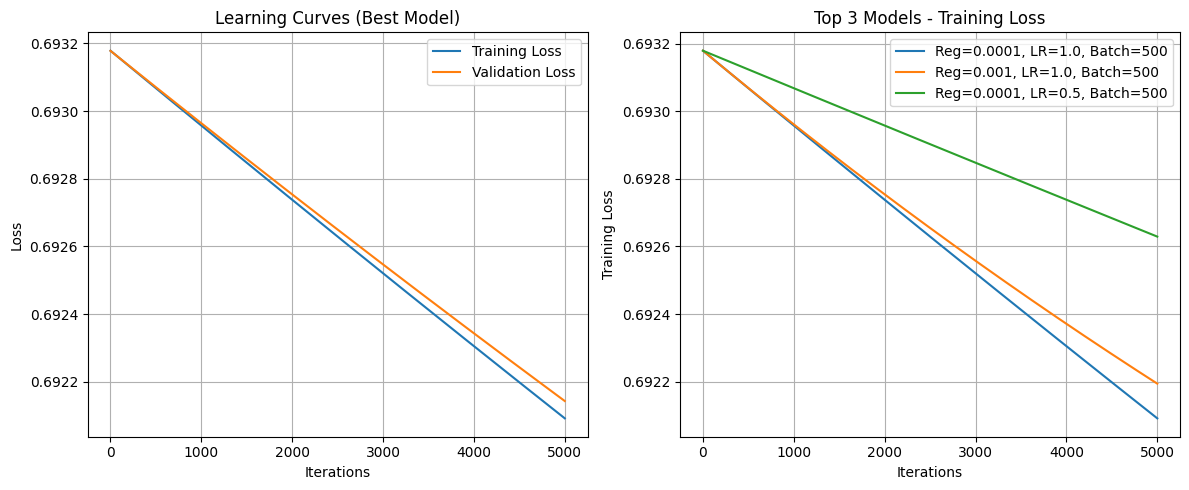


Best hyperparameters: {'reg_param': 0.0001, 'learning_rate': 1.0, 'num_batches': 500}
Best validation loss: 0.692143
****************************************
The loss in iteration  0  is  0.6931669030449604
****************************************
The loss in iteration  1000  is  0.6929478935721101
****************************************
The loss in iteration  2000  is  0.6927305528703154
****************************************
The loss in iteration  3000  is  0.6925148636575571
****************************************
The loss in iteration  4000  is  0.6923008087847188
Test loss: 0.692134
Test accuracy: 0.7923
BFGS test loss: 0.685706
BFGS test accuracy: 0.7920

Final model:
Best hyperparameters: reg_param=0.0001, learning_rate=1.0, num_batches=500
Test accuracy: 0.7923
Trained parameters:
[-17.81601281 -16.87700565 -22.07659265  -5.15623237  28.5961814
   3.55512487 -17.12007153 -19.11523328]
Sample predictions:
[0.49924513 0.49930614 0.49915088 0.49960857 0.49934574 0.49924026
 0

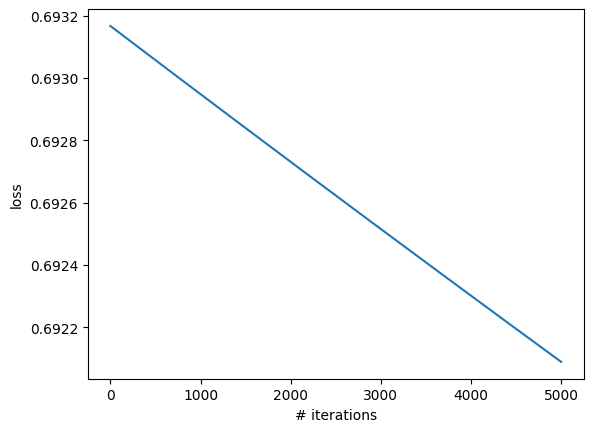

In [14]:
# 1. Find best hyperparameters
best_params, best_model = tune_hyperparameters(X_train, t_train)

# 2. Train final model with best hyperparameters
w_final, test_accuracy, test_pred = train_and_evaluate_with_best_params(
    X_train, t_train, X_test, t_test, best_params
)

# 3. Print final results
print("\nFinal model:")
print(f"Best hyperparameters: reg_param={best_params['reg_param']}, "
      f"learning_rate={best_params['learning_rate']}, num_batches={best_params['num_batches']}")
print(f"Test accuracy: {test_accuracy:.4f}")
print("Trained parameters:")
print(w_final)
print("Sample predictions:")
print(test_pred[:10])

## Q5. Performance measure

There are many ways to compute the performance of a binary classifier. The key concept is the idea of a confusion matrix:

|     &nbsp;         | &nbsp;  | Label | &nbsp;  |
|:-------------:|:--:|:-----:|:--:|
|     &nbsp;         |  &nbsp;  |  0    | 1  |
|**Prediction**| 0  |    TN | FN |
|      &nbsp;        | 1  |    FP | TP |

where
* TP - true positive
* FP - false positive
* FN - false negative
* TN - true negative

Implement three functions:

- `confusion_matrix(y_true, y_pred)`, which returns the confusion matrix as a list of lists given a list of true labels and a list of predicted labels;
- `accuracy(cm)`, which takes a confusion matrix and returns the accuracy; and
- `balanced_accuracy(cm)`, which takes a confusion matrix and returns the balanced accuracy.

The accuracy is defined as $\frac{TP + TN}{n}$, where $n$ is the total number of examples. The balanced accuracy is defined as $\frac{1}{2}\left(\frac{TP}{P} + \frac{TN}{N}\right)$, where $P$ and $N$ are the total number of positive and negative examples respectively.

In [15]:
def confusion_matrix(y_true, y_pred):
    """
    Calculate the confusion matrix given true labels and predicted labels.
    
    Parameters:
    -----------
    y_true : array-like
        True class labels
    y_pred : array-like
        Predicted class labels
    
    Returns:
    --------
    cm : dict of dict
        Confusion matrix as a nested dictionary where cm[true_label][pred_label] 
        gives the count of samples with true label true_label predicted as pred_label.
    """
    # Get unique labels from both true and predicted
    all_labels = set(y_true) | set(y_pred)
    
    # Initialize the confusion matrix as a nested dictionary
    cm = {true_label: {pred_label: 0 for pred_label in all_labels} 
          for true_label in all_labels}
    
    # Fill the confusion matrix
    for true, pred in zip(y_true, y_pred):
        cm[true][pred] += 1
        
    return cm

def accuracy(cm):
    """
    Calculate the accuracy from a confusion matrix.
    
    Parameters:
    -----------
    cm : dict of dict
        Confusion matrix where cm[true_label][pred_label] gives the count 
        of samples with true label true_label predicted as pred_label.
    
    Returns:
    --------
    accuracy : float
        The accuracy score (correct predictions / total predictions)
    """
    correct = 0
    total = 0
    
    for true_label in cm:
        for pred_label in cm[true_label]:
            if true_label == pred_label:
                correct += cm[true_label][pred_label]
            total += cm[true_label][pred_label]
    
    return correct / total if total > 0 else 0

def balanced_accuracy(cm):
    """
    Calculate the balanced accuracy from a confusion matrix.
    Balanced accuracy is the average of recall for each class.
    
    Parameters:
    -----------
    cm : dict of dict
        Confusion matrix where cm[true_label][pred_label] gives the count 
        of samples with true label true_label predicted as pred_label.
    
    Returns:
    --------
    balanced_accuracy : float
        The balanced accuracy score
    """
    recalls = []
    
    for true_label in cm:
        # Sum of all samples with this true label
        class_total = sum(cm[true_label].values())
        
        # Correctly classified samples for this class
        class_correct = cm[true_label].get(true_label, 0)
        
        # Recall for this class
        recall = class_correct / class_total if class_total > 0 else 0
        recalls.append(recall)
    
    # Balanced accuracy is the average of recalls
    return sum(recalls) / len(recalls) if recalls else 0

## Accuracy vs balanced accuracy

What is the purpose of balanced accuracy? When might you prefer it to accuracy?

Balanced accuracy addresses a critical limitation of standard accuracy when dealing with imbalanced datasets.
Balanced accuracy is the average of recall obtained for each class. It's calculated as:

***Balanced Accuracy = (Sensitivity + Specificity) / 2***

For multiclass problems, it's the average recall across all classes:

***Balanced Accuracy = (Recall_Class1 + Recall_Class2 + ... + Recall_ClassN) / N***

## When to Prefer Balanced Accuracy Over Standard Accuracy

1. Imbalanced Class Distributions: The most important use case. When your classes are highly skewed (e.g., 95% negative, 5% positive), standard accuracy can be misleading. A model that always predicts the majority class would get 95% accuracy but be useless for detecting the minority class.
2. Unequal Misclassification Costs: When false negatives and false positives have different consequences. Balanced accuracy gives equal importance to performance on each class.
3. Rare Event Detection: In scenarios like fraud detection, disease diagnosis, or anomaly detection where the positive class is rare but important to identify.
4. Algorithm Comparison: When comparing different algorithms on imbalanced datasets, balanced accuracy provides a fairer assessment of their relative performance.
5. Model Tuning: When optimizing model parameters where you want to ensure good performance across all classes, not just the majority class.

For example, in a medical diagnostic test where only 2% of patients have a rare disease, a model that always predicts "no disease" would achieve 98% accuracy but miss every patient who actually has the disease. Balanced accuracy would reveal this poor performance by equally weighting the recall for both the positive and negative classes.

## Putting everything together

Consider the following code which computes the accuracy and balanced accuracy. Discuss the results. (Your accuaray shoud be better than `[0.75,0.5]`)

In [20]:
test_pred = (test_pred >= 0.5).astype(int)
cmatrix = confusion_matrix(t_test, test_pred)
[accuracy(cmatrix), balanced_accuracy(cmatrix)]

[0.7922616305849839, 0.595731668532465]

In [ ]:
# Discussion of results (compare these two metrics)

## Q6. Looking back at the prediction task

Based on your results, what feature of the dataset is most useful for determining the income level? What feature is least useful? Why?

Hint: take a look at ```w_train```.

In [21]:
# Start your solution here
print(w_final)
# columns = ['income', 'age', 'education', 'private-work', 'married', 'capital-gain', 'capital-loss', 'hours-per-week']

[-17.81601281 -16.87700565 -22.07659265  -5.15623237  28.5961814
   3.55512487 -17.12007153 -19.11523328]


Married status is the most important feature and education is the least important feature
Reasoning:
This is because marital status often correlates with job stability, household structure, and socioeconomic advantages. For example:

Married individuals may have dual-income households or higher financial stability.
Certain tax benefits favor married individuals.
Married men, in particular, tend to earn more on average, possibly due to employer biases or career stability.


In [24]:
pip install pandas seaborn

  Using cached pandas-2.2.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (89 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pytz-2025.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.1-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.3-cp313-cp313-macosx_11_0_arm64.whl (11.3 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached pytz-2025.1-py2.py3-none-any.whl (507 kB)
Using cached tzdata-2025.1-py2.py3-none-any.whl (346 kB)

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.3.5_1/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


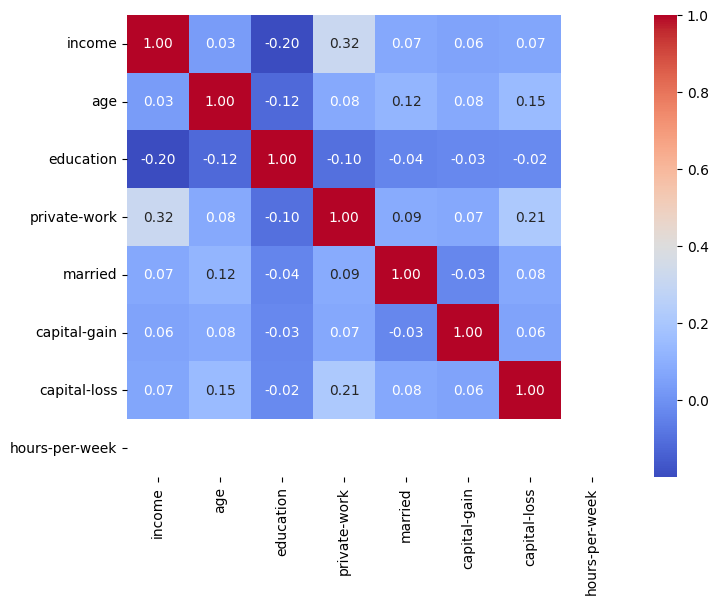

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = pd.DataFrame(X_train, columns=['income', 'age', 'education', 'private-work', 'married', 'capital-gain', 'capital-loss', 'hours-per-week']).corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()


The Relationship Between Education and Income is Non-Linear
Your model is logistic regression, which assumes a linear relationship between features and log-odds.
However, in real life, the impact of education on income is not linear:
Some low-education individuals (e.g., skilled laborers, entrepreneurs) earn more than college graduates.
Some highly educated individuals (e.g., PhDs in low-paying fields) may not earn as much.
A decision tree or non-linear model (like XGBoost) might capture this better.

## Textbook Questions (Optional)
These questions are hand picked to both be of reasonable difficulty and demonstrate what you are expected to be able to solve. The questions are labelled in Bishop as either $\star$, $\star\star$, or $\star\star\star$ to rate its difficulty.

- **Question 4.4**: If you are unfamiliar with lagrange multipliers, look at Appendix E of the textbook. (Difficulty $\star$, simple algebraic derivation)
- **Question 4.5**: (Difficulty $\star$, simple algebraic derivation)
- **Question 1.24**: Note that in the equation $L_{kj}=1-I_{kj}$, $I$ is the identity matrix, so if $k=j$ then $I_{kj}=1$ and $L_{kj}=1-1=0$. (Difficulty $\star\star$, requires good understanding of the formulation of how to minimise expected loss)
- **Question 1.25**: This requires calculus of variations (used much more later in the course), which is in Appendix D, specifically the Euler-Lagrange result. Assume that everything is continuous and continuously differentiable so that you can bring the differentiation inside the integral sign. (Difficulty $\star$, simple extension of proof in textbook to multiple target variables)
- **Question 4.9**: First state the likelihood. When maximising this, what constraints need to be set? Given such constraints, use lagrange multipliers to derive the results. (Difficulty $\star$, simple algebraic derivation)
- **Question 4.10**: For the covariance matrix, you should be able to only use identities from [Sam Roweis' Matrix Identities](https://cs.nyu.edu/~roweis/notes/matrixid.pdf) to derive the result. Note you can use the cyclic property on $$(x_n-\mu_k)^T\Sigma^{-1}(x_n-\mu_k)$$ as it is a square matrix (scalar). (Difficulty $\star\star$, covariance matrix derivation requires uncommon identities)
- **Question 4.11**: (Difficulty $\star\star$, short derivation but requires understanding what the question setup allows you to apply)
- **Question 4.12**: (Difficulty $\star$, simple algebraic derivation)

